### 实验4 循环神经网络实验
#### 数据集介绍 
分类任务：用历史轨迹数据预测下一个签到地点（POI推荐序列）<br>
+ 用户签到数据
+ FourSquare是一个地点推荐网站，类似于国内的大众点评。
+ 当用户到达某个地点时，可以通过手机App进行“签到”(check-in)。
+ 将一个用户所有的签到记录按照时间顺序排序，就能得到此用户的行动轨迹
+ 本实验中使用的数据包含纽约和东京两个城市的用户签到数据，分别存储在 FS_NYC.csv和FS_TKY.csv两个文件中。

In [1]:
import gc
import torch
from torch import nn
import torch.utils.data as Data
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from typing import Tuple, Union


def train_epoch(data_loader: Data.DataLoader, net: nn.Module,
                loss_func, optimizer: torch.optim.Optimizer,
                device='cpu'):
    """
    训练迭代一次
    :param data_loader: 生成器 (x, y)
    :param net:         模型
    :param loss_func:   损失函数
    :param optimizer:   优化器
    :param device:      设备
    :return:    loss, acc
    """
    net.train()
    train_batch_num = max(len(data_loader), 1)

    # 一次迭代中的 Loss、正确样本数、总样本数
    total_loss, correct, sample_num = 0, 0, 0

    for batch_num, (x, y_true) in enumerate(data_loader):

        # 将数据放入指定的设备
        x = x.to(device).float()
        y_true = y_true.to(device).long()

        # 计算损失
        y_hat: torch.Tensor = net(x)
        loss = loss_func(y_hat, y_true)

        # 取概率最大的类别索引
        y_true: torch.Tensor = y_true.view(-1)
        y_hat = y_hat.argmax(dim=1)

        # 反向传播
        optimizer.zero_grad() #清空梯度
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (y_true == y_hat).float().sum().item()
        sample_num += len(y_true)

    loss = total_loss / train_batch_num
    acc = correct / sample_num

    return loss, acc


def test_epoch(data_loader: Data.DataLoader,
               net: nn.Module, loss_func, device='cpu'):
    """
    测试函数迭代一次
    :param data_loader: 生成器 (x, y)
    :param net:         模型
    :param loss_func:   损失函数
    :param device:      设备
    :return:    loss, acc
    """
    net.eval()
    train_batch_num = max(len(data_loader), 1)

    # 一次迭代中的 Loss、正确样本数、总样本数
    total_loss, correct, sample_num = 0, 0, 0

    with torch.no_grad():

        for batch_num, (x, y_true) in enumerate(data_loader):

            # 将数据放入指定的设备
            x = x.to(device).float()
            y_true = y_true.to(device).long()

            # 计算损失
            y_hat: torch.Tensor = net(x)
            loss = loss_func(y_hat, y_true)

            # 取概率最大的类别索引
            y_true: torch.Tensor = y_true.view(-1)
            y_hat = y_hat.argmax(dim=1)

            total_loss += loss.item()
            correct += (y_true == y_hat).float().sum().item()
            sample_num += len(y_true)

    loss = total_loss / train_batch_num
    acc = correct / sample_num

    return loss, acc


def plot_loss_accuracy(train_loss_list, train_acc_list,
                       test_loss_list, test_acc_list, info=''):
    """
    绘制 训练集和测试集正确率、损失值 的图形
    """
    x = np.linspace(0, len(train_loss_list), len(train_loss_list))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 6)
    if info:
        info = info + ' '

    ax1.plot(x, train_loss_list, 'b-', label="train_loss", lw=1)
    ax1.plot(x, test_loss_list, 'r-', label="test_loss", lw=1)
    ax1.set_title(info + 'Loss')
    ax1.legend(loc='best', frameon=False)
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("Loss")

    ax2.plot(x, train_acc_list, 'b-', label="train_accuracy", lw=1)
    ax2.plot(x, test_acc_list, 'r-', label="test_accuracy", lw=1)
    ax2.set_title(info + 'Accuracy')
    ax2.legend(loc='best', frameon=False)
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("Accuracy")

    plt.show()


def plot_by_dict(metrics: dict, shape: Tuple[int, int]):
    """
    绘制图形 {指标: {参数值名1: [], 参数值名2: []}}
    """
    fig, axes = plt.subplots(shape[0], shape[1])
    axes = list(np.array(axes).ravel())
    fig.set_size_inches(10*shape[0], 6*shape[1])

    colors = ['b', 'r', 'y', 'c', 'k', 'g', 'w', 'm']
    for ax_no, title in enumerate(metrics.keys()):
        ax = axes[ax_no]
        for i, (key, values) in enumerate(metrics.get(title, {}).items()):
            x = np.linspace(0, len(values), len(values))
            ax.plot(x, values, colors[i], label=key, lw=1)
            ax.set_title(title)
            ax.legend(loc='best', frameon=False)
            ax.set_xlabel("epoch")
            ax.set_ylabel(title.lower().split(' ')[-1])

    plt.show()

In [2]:
# data_dir = Path('/Users/zhengchubin/PycharmProjects/learn/data/实验4_check-in轨迹数据/')
data_dir = Path('/root/zhengchubin/data/实验4_check-in轨迹数据/')
df = pd.concat([pd.read_csv(data_dir.joinpath('FS_NYC.csv')),
                pd.read_csv(data_dir.joinpath('FS_TKY.csv'))])
df['utcTimestamp'] = pd.to_datetime(df['utcTimestamp'], format='%a %b %d %H:%M:%S %z %Y')

print(df.info(memory_usage=True))
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801131 entries, 0 to 573702
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   userId           801131 non-null  int64              
 1   venueId          801131 non-null  object             
 2   venueCategoryId  801131 non-null  object             
 3   venueCategory    801131 non-null  object             
 4   latitude         801131 non-null  float64            
 5   longitude        801131 non-null  float64            
 6   timezoneOffset   801131 non-null  int64              
 7   utcTimestamp     801131 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(3)
memory usage: 55.0+ MB
None


,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09+00:00
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,2012-04-03 18:00:25+00:00
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,2012-04-03 18:02:24+00:00
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,2012-04-03 18:02:41+00:00
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,2012-04-03 18:03:00+00:00


In [3]:
print(df['utcTimestamp'].min(), df['utcTimestamp'].max())
print(df['venueId'].value_counts())
print(df['userId'].value_counts())

2012-04-03 18:00:09+00:00 2013-02-16 02:35:36+00:00
4b19f917f964a520abe623e3    12372
4b0587a6f964a5203d9e22e3    11891
4b243a7df964a520356424e3     6969
4b093eeff964a520e51423e3     6408
4b0587a6f964a5203e9e22e3     5006
                            ...  
4ceefb7982125481674b67a1        1
4ab53d41f964a520807320e3        1
4fa0856bbb3d40519d3387d5        1
4b5b625af964a520b0f928e3        1
50ada82ce4b0d4508a244756        1
Name: venueId, Length: 100191, dtype: int64
293     3464
822     3107
354     2545
185     2251
207     1991
        ... 
2002     100
1698     100
2181     100
1256     100
1564     100
Name: userId, Length: 2293, dtype: int64


In [4]:
# 预处理
df = df.dropna(subset=['userId', 'venueId', 'venueCategoryId', 'utcTimestamp'])
df = df.sort_values(by=['utcTimestamp'], ascending=True)

# 取后2W条
df = df[-20000:]

# 时间特征
df['day_of_week'] = df['utcTimestamp'].dt.dayofweek
df['hour'] = df['utcTimestamp'].dt.hour

# ID 硬编码
user_id_mapper = {_: i for i,_ in enumerate(df['userId'].unique())}
venue_id_mapper = {_: i for i,_ in enumerate(df['venueId'].unique())}
venue_category_id_mapper = {_: i for i,_ in enumerate(df['venueCategoryId'].unique())}
df['userId'] = df['userId'].map(user_id_mapper)
df['venueId'] = df['venueId'].map(venue_id_mapper)
df['venueCategoryId'] = df['venueCategoryId'].map(venue_category_id_mapper)

# 独热编码
df = pd.concat([df, pd.get_dummies(df['venueCategoryId'], prefix='venueCategoryId')], axis=1)

df = df.reset_index(drop=True)
print(df.shape)
df.head()

(20000, 345)


,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,day_of_week,hour,...,venueCategoryId_325,venueCategoryId_326,venueCategoryId_327,venueCategoryId_328,venueCategoryId_329,venueCategoryId_330,venueCategoryId_331,venueCategoryId_332,venueCategoryId_333,venueCategoryId_334
0,0,0,0,Train Station,35.562478,139.716050,540,2013-02-06 00:47:34+00:00,2,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,Train Station,35.681284,139.766071,540,2013-02-06 00:48:51+00:00,2,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,1,Restaurant,40.746390,-74.000923,-300,2013-02-06 00:49:03+00:00,2,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,0,Train Station,35.669627,139.688855,540,2013-02-06 00:49:05+00:00,2,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,2,Office,35.661705,139.700105,540,2013-02-06 00:49:08+00:00,2,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print(df['utcTimestamp'].min(), df['utcTimestamp'].max())
print(df['venueId'].value_counts())
print(df['userId'].value_counts())


2013-02-06 00:47:34+00:00 2013-02-16 02:35:36+00:00
38      359
52      328
148     216
20      208
19      145
       ... 
1232      1
4823      1
4822      1
4821      1
9309      1
Name: venueId, Length: 9310, dtype: int64
458     159
268      99
339      96
172      83
8        81
       ... 
1685      1
1689      1
688       1
1350      1
1866      1
Name: userId, Length: 1867, dtype: int64


##### 数据集划分
+ `固定长度滑动窗口`<br>
先划分原始长序列，再采样短序列
+ `固定时间窗口滑动`：<br>
固定时间窗口采样得到的序列的长度不一致，无法直接处理为Tensor，需要进行填充&打包。

In [6]:
def slide_window_by_len(seq, wnd_size):
    """
    固定长度滑动窗口
    """
    res = []
    for i in range(len(seq) - wnd_size):
        res.append(seq[i: i + wnd_size])
    return res

def slide_window_by_len_2d(seq: np.array, wnd_size: int):
    """
    固定长度滑动窗口, 新增一个维度
    最后一列为标签值
    """
    res, targets = [], []
    for i in range(seq.shape[0] - wnd_size):
        res.append(seq[i: i + wnd_size -1, :-1])
        targets.append(seq[i + wnd_size, -1])
    return res, targets


# columns = ['userId', 'venueId', 'venueCategoryId', 'latitude', 'longitude', 'timezoneOffset', 'day_of_week', 'hour']
columns = ['userId', 'venueId', 'venueCategoryId', 'latitude', 'longitude', 'timezoneOffset']
# columns += [f'venueCategoryId_{i}' for i in df['venueCategoryId'].unique()]
columns += ['venueId']

# columns = ['venueId']

seq_len = 8
test_size = 0.3

train_x, test_x, train_y, test_y = [], [], [], []
for user, group in df.groupby(by='userId'):

    start_time, end_time = group['utcTimestamp'].min(), group['utcTimestamp'].max()
    group = group.sort_values(by=['utcTimestamp'])

    full_len = group.shape[0]

    # 划分长序列(特征)
    group = group[columns]

    full_seq = group.values
    train_seq = full_seq[:int(full_len * (1-test_size)), :]
    test_seq = full_seq[int(full_len * (1-test_size)):, :]
    train_seq = train_seq.astype(np.float32)
    test_seq = test_seq.astype(np.float32)
    if train_seq.shape[0] < seq_len or test_seq.shape[0] < seq_len:
        continue
    
    # 采样短序列
    x1, y1 = slide_window_by_len_2d(train_seq, wnd_size = seq_len + 1)
    x2, y2 = slide_window_by_len_2d(test_seq, wnd_size = seq_len + 1)

    train_x.extend(x1)
    train_y.extend(y1)
    test_x.extend(x2)
    test_y.extend(y2)

# 新增一个维度
train_x, test_x = torch.tensor(np.stack(train_x)), torch.tensor(np.stack(test_x))
train_y, test_y = torch.tensor(np.array(train_y)), torch.tensor(np.array(test_y))

input_size = train_x.shape[2]
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

train_set = torch.utils.data.TensorDataset(train_x, train_y)
test_set = torch.utils.data.TensorDataset(test_x, test_y)

del train_x, test_x, train_y, test_y
gc.collect()

torch.Size([3287, 8, 6]) torch.Size([3287])
torch.Size([600, 8, 6]) torch.Size([600])


0

#### 手动实现循环神经网络RNN

In [7]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        :param input_size:  输入数据的维度, 若每一步的输入均为一个采样值，则input_size=1
        :param hidden_size: 指定隐藏状态的维度
        :param output_size: 指定输出数据的维度
        """
        super().__init__()
        self.hidden_size = hidden_size

        self.w_i = nn.Parameter(torch.normal(0.0, 0.01, size=(input_size, hidden_size)))
        self.b_i = nn.Parameter(torch.normal(0.0, 0.01, size=(hidden_size,)))

        self.w_h = nn.Parameter(torch.normal(0.0, 0.01, size=(hidden_size, hidden_size)))
        self.b_h = nn.Parameter(torch.normal(0.0, 0.01, size=(hidden_size,)))

        self.w_y = nn.Parameter(torch.normal(0.0, 0.01, size=(hidden_size, output_size)))
        self.b_y = nn.Parameter(torch.normal(0.0, 0.01, size=(output_size,)))

        # 激活函数
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()

        # 参数初始化
        for param in self.parameters():
            nn.init.normal_(param, std=0.01)
            # nn.init.xavier_uniform_(param)

    def forward(self, x: torch.Tensor):
        """
        :param x: 输入序列, 包含3个维度：batch,序列长度,每条数据的特征
        """
        batch_size = x.shape[0]
        seq_len = x.shape[1]

        # 初始化隐藏状态，一般设为全0
        h = torch.zeros(batch_size, self.hidden_size)

        # RNN 实际上只能一步步处理序列。Many to one
        for i in range(seq_len):
            h = torch.matmul(x[:, i, :], self.w_i) + self.b_i \
                + torch.matmul(h, self.w_h) + self.b_h
            h = self.tanh(h)

        y = torch.matmul(h, self.w_y) + self.b_y
        y = self.leaky_relu(y)
        # y = self.softmax(y)

        return y

MyRNN(
  (tanh): Tanh()
  (leaky_relu): LeakyReLU(negative_slope=0.01)
)
epoch 1, train_loss 9.104562, test_loss 9.032764, train_acc 0.008518, test_acc 0.013333
epoch 2, train_loss 8.951940, test_loss 8.869401, train_acc 0.016428, test_acc 0.015000
epoch 3, train_loss 8.731595, test_loss 8.645926, train_acc 0.016428, test_acc 0.013333
epoch 4, train_loss 8.505341, test_loss 8.451196, train_acc 0.016124, test_acc 0.013333
epoch 5, train_loss 8.313624, test_loss 8.276312, train_acc 0.016124, test_acc 0.013333
epoch 6, train_loss 8.158247, test_loss 8.152005, train_acc 0.016124, test_acc 0.013333
epoch 7, train_loss 8.033395, test_loss 8.089427, train_acc 0.019775, test_acc 0.015000
epoch 8, train_loss 7.921438, test_loss 8.027202, train_acc 0.020688, test_acc 0.016667
epoch 9, train_loss 7.827348, test_loss 7.997344, train_acc 0.021296, test_acc 0.016667
epoch 10, train_loss 7.732346, test_loss 8.027237, train_acc 0.021296, test_acc 0.016667
epoch 11, train_loss 7.657397, test_loss 7.965

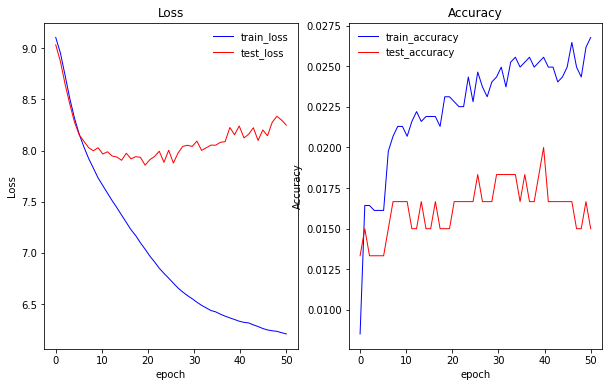

In [8]:
# 参数配置
device = 'cpu'
batch_size = 256
input_size = input_size
hidden_size = 32
output_size = len(venue_id_mapper)
num_epochs = 50
lr = 0.003

net = MyRNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
print(net)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                        loss_func=loss_func, optimizer=optimizer, device=device)
    test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                     loss_func=loss_func, device=device)

    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
          % (epoch+1, train_loss, test_loss, train_acc, test_acc))

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

plot_loss_accuracy(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

#### torch.nn.rnn实现循环神经网络

In [9]:
class TorchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = 1
 
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=self.num_layers,
        )
 
        self.softmax = nn.Linear(hidden_size, output_size)
 
    def forward(self, x):
        batch_size = x.shape[0]

        # 初始化隐藏状态，一般设为全0
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        output, hn = self.rnn(x, h0)
        return self.softmax(output[:, -1, :])  # 选取最后一个时刻的output

TorchRNN(
  (rnn): RNN(6, 32, batch_first=True)
  (softmax): Linear(in_features=32, out_features=9310, bias=True)
)
epoch 1, train_loss 9.261582, test_loss 9.254832, train_acc 0.000000, test_acc 0.000000
epoch 2, train_loss 9.210853, test_loss 9.200077, train_acc 0.000000, test_acc 0.000000
epoch 3, train_loss 9.158226, test_loss 9.134293, train_acc 0.003651, test_acc 0.016667
epoch 4, train_loss 9.101895, test_loss 9.119974, train_acc 0.017037, test_acc 0.013333
epoch 5, train_loss 9.050653, test_loss 9.061384, train_acc 0.016124, test_acc 0.015000
epoch 6, train_loss 9.031100, test_loss 9.029004, train_acc 0.014907, test_acc 0.013333
epoch 7, train_loss 8.983955, test_loss 8.995464, train_acc 0.015211, test_acc 0.016667
epoch 8, train_loss 8.938964, test_loss 8.997934, train_acc 0.015820, test_acc 0.018333
epoch 9, train_loss 8.898528, test_loss 8.930973, train_acc 0.018254, test_acc 0.018333
epoch 10, train_loss 8.864326, test_loss 8.909440, train_acc 0.017949, test_acc 0.016667
epo

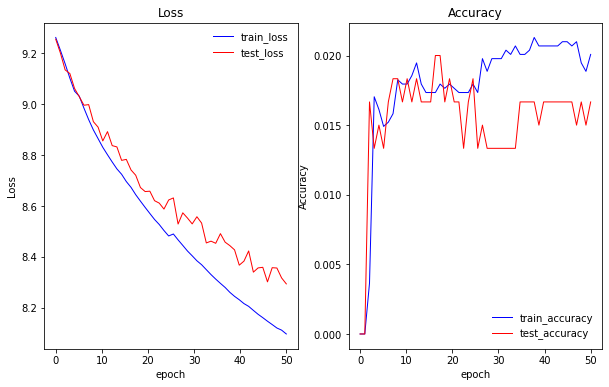

In [10]:
# 参数配置
batch_size = 256
input_size = input_size
hidden_size = 32
output_size = len(venue_id_mapper)
num_epochs = 50
lr = 0.1

net = TorchRNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
print(net)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                        loss_func=loss_func, optimizer=optimizer, device=device)
    test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                     loss_func=loss_func, device=device)

    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
          % (epoch+1, train_loss, test_loss, train_acc, test_acc))

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

plot_loss_accuracy(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

#### 超参数的对比分析

TorchRNN(
  (rnn): RNN(6, 32, batch_first=True)
  (softmax): Linear(in_features=32, out_features=9310, bias=True)
)
lr=1.0 epoch 1, train_loss 68.129026, test_loss 107.673070, train_acc 0.002738, test_acc 0.001667
lr=1.0 epoch 2, train_loss 110.917266, test_loss 164.478597, train_acc 0.003042, test_acc 0.003333
lr=1.0 epoch 3, train_loss 130.087670, test_loss 203.842311, train_acc 0.001521, test_acc 0.001667
lr=1.0 epoch 4, train_loss 131.578502, test_loss 215.301966, train_acc 0.001521, test_acc 0.000000
lr=1.0 epoch 5, train_loss 140.296381, test_loss 244.204503, train_acc 0.001217, test_acc 0.000000
lr=1.0 epoch 6, train_loss 160.228010, test_loss 265.079336, train_acc 0.000913, test_acc 0.000000
lr=1.0 epoch 7, train_loss 185.838526, test_loss 316.522685, train_acc 0.001521, test_acc 0.010000
lr=1.0 epoch 8, train_loss 216.250405, test_loss 362.809875, train_acc 0.002130, test_acc 0.006667
lr=1.0 epoch 9, train_loss 245.198784, test_loss 406.467896, train_acc 0.002130, test_acc 0.0

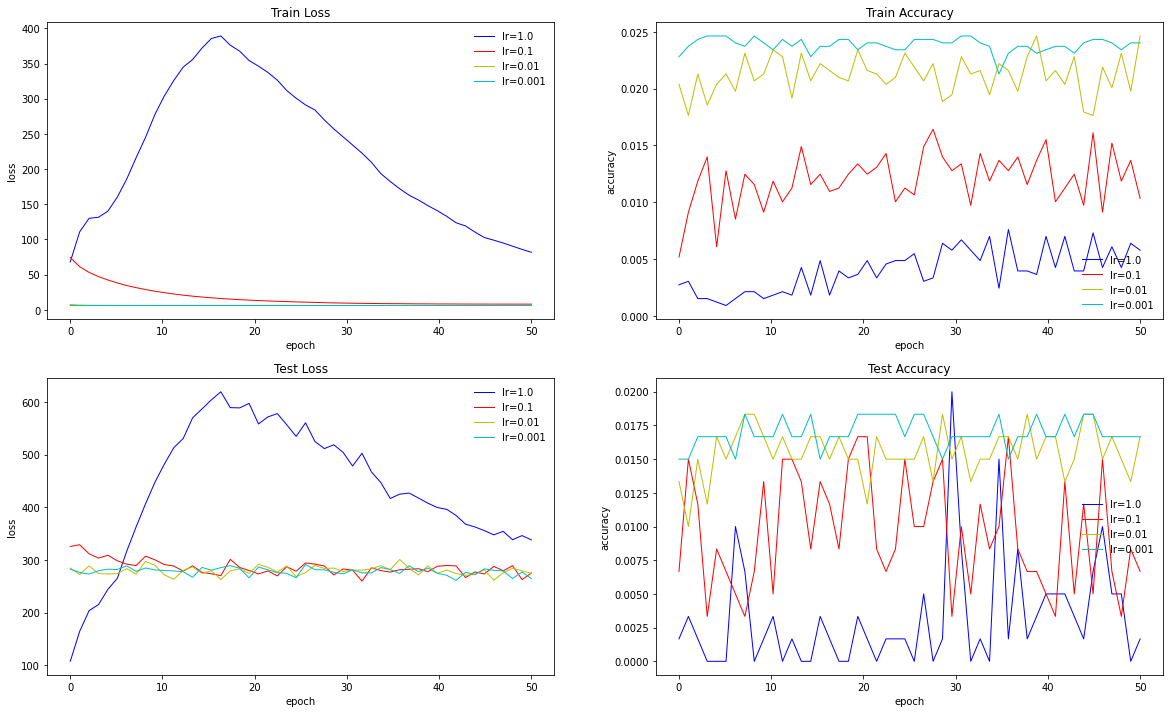

In [11]:
# 参数配置
batch_size = 256
input_size = input_size
hidden_size = 32
output_size = len(venue_id_mapper)
num_epochs = 50
lr = 0.1

net = TorchRNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
print(net)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)


metric_dic = {
    'Train Loss': {},
    'Train Accuracy': {},
    'Test Loss': {},
    'Test Accuracy': {},
}

for lr in [1.0, 0.1, 0.01, 0.001]:

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

        train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                            loss_func=loss_func, optimizer=optimizer, device=device)
        test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                         loss_func=loss_func, device=device)

        print('lr=%s epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
              % (lr, epoch+1, train_loss, test_loss, train_acc, test_acc))

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

    metric_dic['Train Loss'][f'lr={lr}'] = train_loss_list
    metric_dic['Train Accuracy'][f'lr={lr}'] = train_acc_list
    metric_dic['Test Loss'][f'lr={lr}'] = test_loss_list
    metric_dic['Test Accuracy'][f'lr={lr}'] = test_acc_list

plot_by_dict(metric_dic, shape=(2, 2))


#### 使用PyTorch实现 LSTM

In [12]:
class TorchLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size,
                 num_layers = 1, bidirectional=False):
        super(TorchLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(
            input_size=input_size,
            batch_first=True,
            hidden_size=hidden_size,
            bidirectional=self.bidirectional,
            num_layers=self.num_layers
        )
        if bidirectional:
            hidden_size = 2 * self.num_layers * hidden_size
        else:
            hidden_size = self.num_layers * hidden_size

        self.softmax = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor):
        # LSTM
        if self.bidirectional:
            outputs,(h_n, c_n) = self.lstm(x, None)  # (h, c)

            output_fw = h_n[-2, :, :]  # 正向最后一次的输出
            output_bw = h_n[-1, :, :]  # 反向最后一次的输出
            output = torch.cat([output_fw, output_bw], dim=-1)
        else:
            # [128, 30, 32]
            output, _ = self.lstm(x, None)  # h

            # 选取最后一个时刻的输出 [128, 32]
            output = output[:, -1, :]

        output = self.softmax(output)
        return output

TorchLSTM(
  (lstm): LSTM(6, 32, batch_first=True)
  (softmax): Linear(in_features=32, out_features=9310, bias=True)
)
epoch 1, train_loss 9.196412, test_loss 9.194424, train_acc 0.000000, test_acc 0.000000
epoch 2, train_loss 9.173744, test_loss 9.174764, train_acc 0.000000, test_acc 0.000000
epoch 3, train_loss 9.163891, test_loss 9.170076, train_acc 0.000000, test_acc 0.000000
epoch 4, train_loss 9.146211, test_loss 9.153725, train_acc 0.000000, test_acc 0.000000
epoch 5, train_loss 9.134428, test_loss 9.154624, train_acc 0.001217, test_acc 0.001667
epoch 6, train_loss 9.121261, test_loss 9.143652, train_acc 0.006389, test_acc 0.008333
epoch 7, train_loss 9.109662, test_loss 9.132694, train_acc 0.014907, test_acc 0.011667
epoch 8, train_loss 9.096899, test_loss 9.121753, train_acc 0.018254, test_acc 0.013333
epoch 9, train_loss 9.084585, test_loss 9.105120, train_acc 0.017645, test_acc 0.011667
epoch 10, train_loss 9.070564, test_loss 9.095808, train_acc 0.018558, test_acc 0.013333


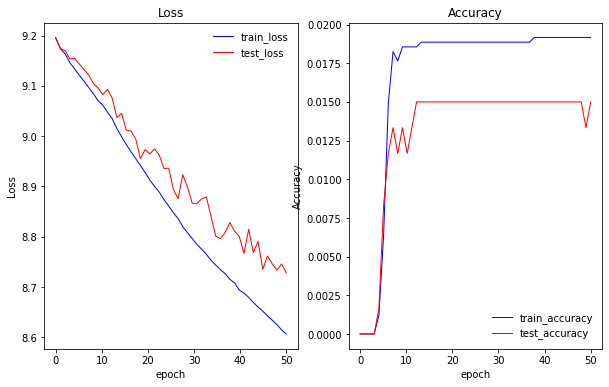

In [13]:
# 参数配置
batch_size = 256
input_size = input_size
hidden_size = 32
output_size = len(venue_id_mapper)
num_epochs = 50
lr = 0.1

net = TorchLSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
print(net)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                        loss_func=loss_func, optimizer=optimizer, device=device)
    test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                     loss_func=loss_func, device=device)

    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
          % (epoch+1, train_loss, test_loss, train_acc, test_acc))

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

plot_loss_accuracy(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

#### 使用PyTorch实现 GRU


In [14]:
class TorchGRU(nn.Module):

    def __init__(self, input_size, hidden_size, output_size,
                 num_layers = 1, bidirectional=False):
        super(TorchGRU, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.GRU(
            input_size=input_size,
            batch_first=True,
            hidden_size=hidden_size,
            bidirectional=self.bidirectional,
            num_layers=self.num_layers
        )
        if bidirectional:
            hidden_size = 2 * self.num_layers * hidden_size
        else:
            hidden_size = self.num_layers * hidden_size

        self.softmax = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor):
        # LSTM
        if self.bidirectional:
            outputs,(h_n, c_n) = self.lstm(x, None)  # (h, c)

            output_fw = h_n[-2, :, :]  # 正向最后一次的输出
            output_bw = h_n[-1, :, :]  # 反向最后一次的输出
            output = torch.cat([output_fw, output_bw], dim=-1)
        else:
            # [128, 30, 32]
            output, _ = self.lstm(x, None)  # h

            # 选取最后一个时刻的输出 [128, 32]
            output = output[:, -1, :]

        output = self.softmax(output)
        return output

TorchGRU(
  (lstm): GRU(6, 32, batch_first=True)
  (softmax): Linear(in_features=32, out_features=9310, bias=True)
)
epoch 1, train_loss 9.241559, test_loss 9.225738, train_acc 0.000000, test_acc 0.000000
epoch 2, train_loss 9.208781, test_loss 9.180490, train_acc 0.000000, test_acc 0.000000
epoch 3, train_loss 9.174874, test_loss 9.150898, train_acc 0.000304, test_acc 0.000000
epoch 4, train_loss 9.138171, test_loss 9.123480, train_acc 0.000913, test_acc 0.008333
epoch 5, train_loss 9.102584, test_loss 9.105041, train_acc 0.012778, test_acc 0.011667
epoch 6, train_loss 9.068186, test_loss 9.074599, train_acc 0.016733, test_acc 0.015000
epoch 7, train_loss 9.032930, test_loss 9.027947, train_acc 0.018558, test_acc 0.015000
epoch 8, train_loss 9.000753, test_loss 8.993354, train_acc 0.018862, test_acc 0.015000
epoch 9, train_loss 8.966360, test_loss 8.990556, train_acc 0.018862, test_acc 0.015000
epoch 10, train_loss 8.936684, test_loss 8.938504, train_acc 0.018862, test_acc 0.015000
ep

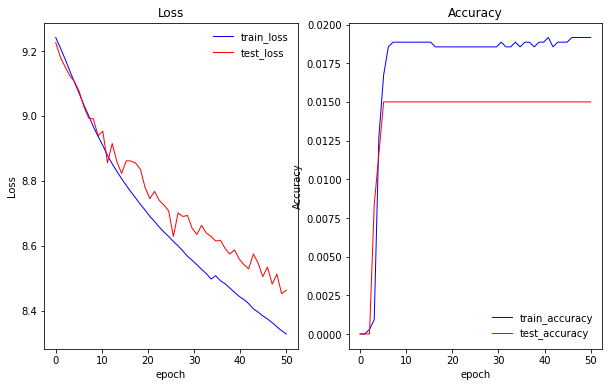

In [20]:
# 参数配置
batch_size = 256
input_size = input_size
hidden_size = 32
output_size = len(venue_id_mapper)
num_epochs = 50
lr = 0.1

net = TorchGRU(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
print(net)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                        loss_func=loss_func, optimizer=optimizer, device=device)
    test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                     loss_func=loss_func, device=device)

    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
          % (epoch+1, train_loss, test_loss, train_acc, test_acc))

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

plot_loss_accuracy(train_loss_list, train_acc_list, test_loss_list, test_acc_list)